#Import and setup

In [ ]:
from IPython.display import clear_output

In [ ]:
# !pip install datasets transformers torchmetrics evaluate
# !pip install --upgrade accelerate
# !pip install umap-learn
# clear_output()

In [ ]:
import torch
from torch import matmul, exp, log, abs
import torch.nn as nn
from torch.utils.data import DataLoader
import plotly.express as px
from IPython.display import clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, BertModel, ElectraModel, set_seed
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers import AdamW,get_scheduler

from datasets import load_metric, load_dataset
import umap
import random
import numpy as np
import evaluate

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Setting seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

set_seed(seed = SEED)

In [ ]:
# language model hyper parameters
batch_size = 16
epochs = 10
lr = 5e-5
weight_decay = 0.1
tau = 50
alpha = 0.3

# Dataset

In [ ]:
dataset_name = 'go_emotions'

In [ ]:
if dataset_name == 'sst2':
    dataset = load_dataset('sst2')
    num_labels = 2
elif dataset_name == 'sst2_aug':
    dataset = load_dataset("gokuls/glue_augmented_sst2")
    num_labels = 2
elif dataset_name == 'sst5':
    dataset = load_dataset('SetFit/sst5')
    num_labels = 5
elif dataset_name == 'imdb':
    dataset = load_dataset('imdb')
    num_labels = 2
elif dataset_name == 'ag_news':
    dataset = load_dataset("ag_news")
    num_abels = 4
elif dataset_name == 'go_emotions':
    dataset = load_dataset("go_emotions", "simplified")
    num_labels = 27
clear_output()

In [ ]:
train_dataset = dataset["train"].shuffle(seed=42)
# train_dataset = t['train'].select([i for i in list(range(1000))])
# eval_dataset = t['test'].select([i for i in list(range(300))])

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

# Contrastive Loss functions

In [ ]:
def no_pos_in_denomenaor_loss(logits, labels):
    '''
    Here logits have the shpae [batch_size, num_toekens, 768]
    and labels is a vector of target labels.
    '''
    # normalizing hyper parameter
    t = tau

    # Initilize
    loss = 0

    # Take the mean of all the tokens in a sentence except [CLS]
    mean_representations = torch.mean(logits[:, 1:-1, :], axis=1)

    # for each mean representation
    for i, repr in enumerate(mean_representations):
        positives = []
        negatives = []

        # find negative and positive set
        for j in range(len(labels)):

            # if i and j have different labels then they are negative
            if labels[i] != labels[j]:
                negatives.append(mean_representations[j].tolist())

            # else if they have the same labels and i should not be in it's positive set
            elif i != j:
                positives.append(mean_representations[j].tolist())

        #if positive set is empty loss would be zero !!!!!!!
        if len(positives) != 0:
              positives = torch.tensor(positives).to(device)
              negatives = torch.tensor(negatives).to(device)

              # sigma on positive set
              pos_sum = torch.sum(torch.exp((positives @ repr) / t))

              # sigma on negative set
              neg_sum = torch.sum(torch.exp((negatives @ repr) / t))

              loss += -torch.log(pos_sum/neg_sum)

    return loss if loss > 0 else torch.tensor(0.0, dtype=torch.float32, device='cuda:0', requires_grad=True)


In [ ]:
def SCL(logits, labels):
  t = tau

  loss = 0

  mean_logits = torch.mean(logits[:, 1:-1, :], axis=1)

  for i, logit in enumerate(mean_logits):

    positives = [mean_logits[j].tolist() for j in range(len(labels)) if not j == i and labels[i] == labels[j]]

    if len(positives) != 0:
      positives = torch.tensor(positives).to(device)
      others = torch.cat((mean_logits[0:i], mean_logits[i+1:]))

      others_sum = torch.sum(torch.exp((others @ logit) / t))
      pos_sum = torch.sum(torch.log(torch.exp((positives @ logit) / t) / others_sum))
      loss += -pos_sum/len(positives)

  return loss if loss != 0 else torch.tensor(0.0, dtype=torch.float32, device='cuda:0', requires_grad=True)

In [ ]:
def LCL(reps, w, labels):
  # t = 0.07
  loss = 0
  w = nn.functional.softmax(w, dim=1)[range(labels.shape[0]), labels]
  # mean_reps = torch.mean(reps[:, 1:-1, :], axis=1)
  mean_reps = reps[:, 0, :]

  for i, rep in enumerate(mean_reps):
    # loss -= torch.log(logit[labels[i]])
    positives = [mean_reps[j].tolist() for j in range(len(labels)) if not j == i and labels[i] == labels[j]]
    p_w = [w[j].tolist() for j in range(len(labels)) if not j == i and labels[i] == labels[j]]

    if len(positives) != 0:
      positives = torch.tensor(positives).to(device)
      p_w = torch.tensor(p_w).to(device)
      others = torch.cat((mean_reps[0:i], mean_reps[i+1:]))
      o_w = torch.cat((w[0:i], w[i+1:]))

      others_sum = torch.sum(o_w * torch.exp((others @ rep) / t))
      pos_sum = torch.sum(p_w * torch.log(torch.exp((positives @ rep) / t) / others_sum))
      loss += -pos_sum/len(positives)

  return loss if loss != 0 else torch.tensor(0.0, dtype=torch.float32, device='cuda:0', requires_grad=True)


# Trainer Classes

In [ ]:
class JointTrainer(Trainer):
    '''
    Try to train model and classifier jointly
    '''

    def compute_loss(self, model, inputs, return_outputs=False):
        LM = model.electra
        classifier = model.classifier
        labels = inputs.pop("labels")
        # outs = model(**inputs)
        # print(outs)
        # print(outs.size())
        #forward pass
        outputs = LM(**inputs)
        logits = outputs[0]
        # print(outputs)
        # compute contrastive loss with representations
        contrastive_loss = no_pos_in_denomenaor_loss(logits, labels)
        # print(logits.size())

        logits = classifier(logits)

        # compute loss
        loss_fn = nn.CrossEntropyLoss()

        classifier_loss = loss_fn(logits, labels)
        loss = torch.max(torch.tensor(0), alpha*classifier_loss + (1-alpha)*contrastive_loss)
        outputs = logits
        # print(outputs)
        # print(outputs.size())
        return  (loss, outputs) if return_outputs else loss



In [ ]:
class MyTrainer(Trainer):
    '''
        Use the Trainer class but only change its compute_loss function
        to use contrastive loss.
    '''

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0]
        loss = no_pos_in_denomenaor_loss(logits, labels)
        return  (loss, outputs) if return_outputs else loss

# Models

In [ ]:
class LMClassifierHead_v0(nn.Module):
    '''
    Add classifier head to the language model
    '''
    def __init__(self,model,num_labels):
        super(LMClassifierHead,self).__init__()
        self.num_labels = num_labels

        #Load Model with given checkpoint and extract its body
        self.model = model

        self.dropout = torch.nn.Dropout(0.3, inplace=False)
        self.dense = torch.nn.Linear(in_features=768, out_features=768, bias=True)
        self.out_proj = torch.nn.Linear(in_features=768, out_features=num_labels, bias=True)
        self.act = torch.nn.Tanh()

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        print('here')
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        print('there')
        #Add custom layers
        x = self.dropout(outputs[0]) # Outputs[0] = last_hidden_state
        x = self.dense(torch.mean(x[:, 1:-1, :], axis=1).view(-1,768)) # Take the mean
        x = self.act(x)
        x = self.dropout(x)
        logits = self.out_proj(x) # get logits (prediction for each class)

        # calculate loss
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
class LMClassifierHead(nn.Module):
    '''
    Add classifier head to the language model
    '''
    def __init__(self,model,num_labels):
        super(LMClassifierHead,self).__init__()
        self.num_labels = num_labels

        #Load Model with given checkpoint and extract its body
        self.model = model

        self.dropout = torch.nn.Dropout(0.1)
        self.dense = torch.nn.Linear(in_features=768, out_features=768)
        self.out_proj = torch.nn.Linear(in_features=768, out_features=num_labels)
        self.act = torch.nn.ReLU() #try lakey 0.1
        self.classifier = torch.nn.Linear(768,2048) # load and initialize weights
        self.mid = nn.Linear(2048, 2048)
        self.linear = torch.nn.Linear(2048,768)

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)


        sequence_output = self.dropout(outputs[0])
        logits = self.act(self.classifier(torch.mean(sequence_output[:, 1:-1, :], axis=1).view(-1,768))) # calculate losses
        logits = self.act(self.linear(logits))
        logits = self.out_proj(logits)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
class LCLModel(nn.Module):
  def __init__(self, rep_model, weight_model, num_labels, alpha):
    super(LCLModel,self).__init__()
    self.num_labels = num_labels

    #Load Model with given checkpoint and extract its body
    self.rep_model = rep_model
    self.weight_model = weight_model
    self.dropout = torch.nn.Dropout(0.1)
    self.weight_classifier = torch.nn.Linear(num_labels, num_labels)
    self.classifier = torch.nn.Linear(768,num_labels) # load and initialize weights
    self.layer = torch.nn.Linear(768,768)
  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    reps = self.rep_model(input_ids=input_ids, attention_mask=attention_mask)
    w = self.weight_model(input_ids=input_ids, attention_mask=attention_mask)

    lcl = LCL(reps[0], w[0], labels)
    #Add custom layers


    sequence_output = self.dropout(w[0]) #outputs[0]=last hidden state
    logits = self.weight_classifier(sequence_output.view(-1, self.num_labels)) # calculate losses
    Lw = None
    if labels is not None:
      loss_fct = torch.nn.CrossEntropyLoss()
      Lw = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))


    sequence_output = self.dropout(reps[0]) #outputs[0]=last hidden state
    x= self.layer(sequence_output[:,0,:].view(-1,768))
    act = nn.functional.relu(x)
    logits = self.classifier(act)
    # logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    Le = None
    if labels is not None:
      loss_fct = torch.nn.CrossEntropyLoss()
      Le = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=alpha*(Le + Lw) + (1-alpha) * lcl, logits=logits, hidden_states=reps.hidden_states,attentions=reps.attentions)

In [ ]:
class SCLModel(nn.Module):
  def __init__(self, rep_model, num_labels):
    super(SCLModel,self).__init__()
    self.num_labels = num_labels

    #Load Model with given checkpoint and extract its body
    self.rep_model = rep_model
    self.dropout = torch.nn.Dropout(0.1)
    self.classifier = torch.nn.Linear(768,num_labels) # load and initialize weights
    self.layer = torch.nn.Linear(768,768)

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    reps = self.rep_model(input_ids=input_ids, attention_mask=attention_mask)
    scl = SCL(reps[0], labels)
    #Add custom layers

    sequence_output = self.dropout(reps[0]) #outputs[0]=last hidden state
    x = self.layer(sequence_output[:,0,:].view(-1,768))
    act = nn.functional.relu(x)
    logits = self.classifier(act)
    # logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    Le = None
    if labels is not None:
      loss_fct = torch.nn.CrossEntropyLoss()
      Le = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=alpha*Le + (1-alpha) * scl, logits=logits, hidden_states=reps.hidden_states,attentions=reps.attentions)

# Loading and tokenizing

In [ ]:
# import numpy as np
# import umap
# import matplotlib.pyplot as plt
# from transformers import ElectraTokenizer, ElectraForSequenceClassification
# from datasets import load_dataset

# # Load the ELECTRA model and tokenizer
# model_name = "google/electra-small-discriminator"
# model = ElectraForSequenceClassification.from_pretrained(model_name)
# tokenizer = ElectraTokenizer.from_pretrained(model_name)

# # Load the SST-5 dataset
# dataset = load_dataset('glue', 'sst2')

# # Get the embeddings for all sentences in the dataset
# sentences = dataset['train']['sentence']
# embeddings = []
# for sentence in tqdm(sentences):
#     encoded = tokenizer.encode_plus(sentence, return_tensors='pt')
#     with torch.no_grad():
#         output = model(**encoded, output_hidden_states=True)
#         hidden_states = output.hidden_states
#         embeddings.append(hidden_states[-1][0][0].numpy())

# # Apply UMAP to the embeddings to obtain a 2D projection
# umap_embeddings = umap.UMAP(n_neighbors=5, min_dist=0.3).fit_transform(embeddings)

# # Plot the UMAP projection
# plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=dataset['train']['label'])
# plt.colorbar()
# plt.show()

In [ ]:
# lcl_model = LCLModel(rep_model=lcl_rep_model, weight_model=weight_model,num_labels=num_labels).to(device)


In [ ]:
checkpoint = "google/electra-base-discriminator"
# checkpoint = 'TehranNLP-org/electra-base-sst2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels).to(device)
clear_output()

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [ ]:
def filter_func(example):
    return len(example["labels"]) == 1 and example["labels"][0] != 27

def tokenize_function(example):
    example['labels'] = list(map(lambda x: x[0], example['labels']))
    example['label'] = example.pop('labels')
    return tokenizer(example["text"], truncation=True)

tokenized_train = dataset['train'].shuffle(seed=SEED).select([i for i in list(range(8000))]).filter(filter_func).map(tokenize_function, batched=True)
tokenized_valid = dataset['validation'].filter(filter_func).map(tokenize_function, batched=True)
tokenized_test = dataset['test'].filter(filter_func).map(tokenize_function, batched=True)

clear_output()

In [ ]:
tokenized_train.set_format("torch",columns=["input_ids", "attention_mask", "label"])
tokenized_valid.set_format("torch",columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training with trainer

In [ ]:
torch.cuda.empty_cache()

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # print(logits.shape, labels.shape)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    # learning_rate=lr,
    # weight_decay=weight_decay,
    # optim = "adamw_torch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs=epochs,
    warmup_steps=2000,
    # evaluation_strategy='steps',
    save_strategy="steps",
    logging_steps=64,
    save_steps=512,
    overwrite_output_dir=True,
    save_total_limit=10,
)

trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset= tokenized_valid,
    # compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
64,3.295000
128,3.271300
192,3.230700
256,3.159300
320,3.071100
384,3.026300
448,2.939500
512,2.764500
576,2.625000
640,2.434800


TrainOutput(global_step=2700, training_loss=1.5140633173342104, metrics={'train_runtime': 375.1222, 'train_samples_per_second': 114.763, 'train_steps_per_second': 7.198, 'total_flos': 747589194845460.0, 'train_loss': 1.5140633173342104, 'epoch': 10.0})

file name format:

model_dataset_finetuningEpochs_fineTunningBatchSize_lossFunction_classifierEpochs_classifierbatchsize

In [ ]:
# save the model
saved_model_name = './electra_sst5_sst2_pretrianed'
trainer.save_model(saved_model_name)

In [ ]:
# load saved model
model = AutoModel.from_pretrained(saved_model_name).to(device)
clear_output()

In [ ]:
trainer.evaluate()

{'eval_loss': 1.8839740753173828,
 'eval_runtime': 6.445,
 'eval_samples_per_second': 458.648,
 'eval_steps_per_second': 28.704,
 'epoch': 10.0}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [ ]:
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
metric = evaluate.load('accuracy')
acc= metric.compute(predictions=preds, references=predictions.label_ids)
metric = evaluate.load('recall')
rec = metric.compute(predictions=preds, references=predictions.label_ids)
metric = evaluate.load('precision')
pre = metric.compute(predictions=preds, references=predictions.label_ids)
metric = evaluate.load('f1')
f1 = metric.compute(predictions=preds, references=predictions.label_ids)
print(f1, rec, pre, acc, end='\n')

ValueError: ignored

# Classifier

In [ ]:
model.electra

In [ ]:
# freeze language model
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# classifier hyper parameters
classifier_batch = 1
classifier_epochs = 5
lr = 5e-5
weight_decay = 0.1

In [ ]:
train_dataloader = DataLoader(
    tokenized_train, shuffle=True, batch_size=classifier_batch, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    tokenized_valid, batch_size=classifier_batch, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_test, batch_size=classifier_batch, collate_fn=data_collator
)

In [ ]:
train_outs = []
train_labels = []
model.to(device)
with torch.no_grad():
  for j, batch in enumerate(tqdm(train_dataloader)):
    labels = batch.pop('labels')
    batch = batch.to(device)
    x = model(**batch)['last_hidden_state'][0]
    x = torch.mean(x[1:], axis=0)
    train_outs+=x
    train_labels += labels

  0%|          | 0/4305 [00:00<?, ?it/s]

In [ ]:
test_outs = []
test_labels = []
model.to(device)
with torch.no_grad():
  for j, batch in enumerate(tqdm(test_dataloader)):
    labels = batch.pop('labels')
    batch = batch.to(device)
    x = model(**batch)['last_hidden_state'][0]
    x = torch.mean(x[1:], axis=0)
    test_outs+=x
    test_labels += labels

  0%|          | 0/2984 [00:00<?, ?it/s]

In [ ]:
stack_outs = torch.stack(train_outs, dim=0).cpu().numpy().reshape(-1, 768)

In [ ]:
test_stack_outs = torch.stack(test_outs, dim=0).cpu().numpy().reshape(-1, 768)

In [ ]:
# Apply UMAP to the embeddings to obtain a 2D projection
umap_embeddings = umap.UMAP(n_neighbors=27, min_dist=0.3).fit_transform(stack_outs)

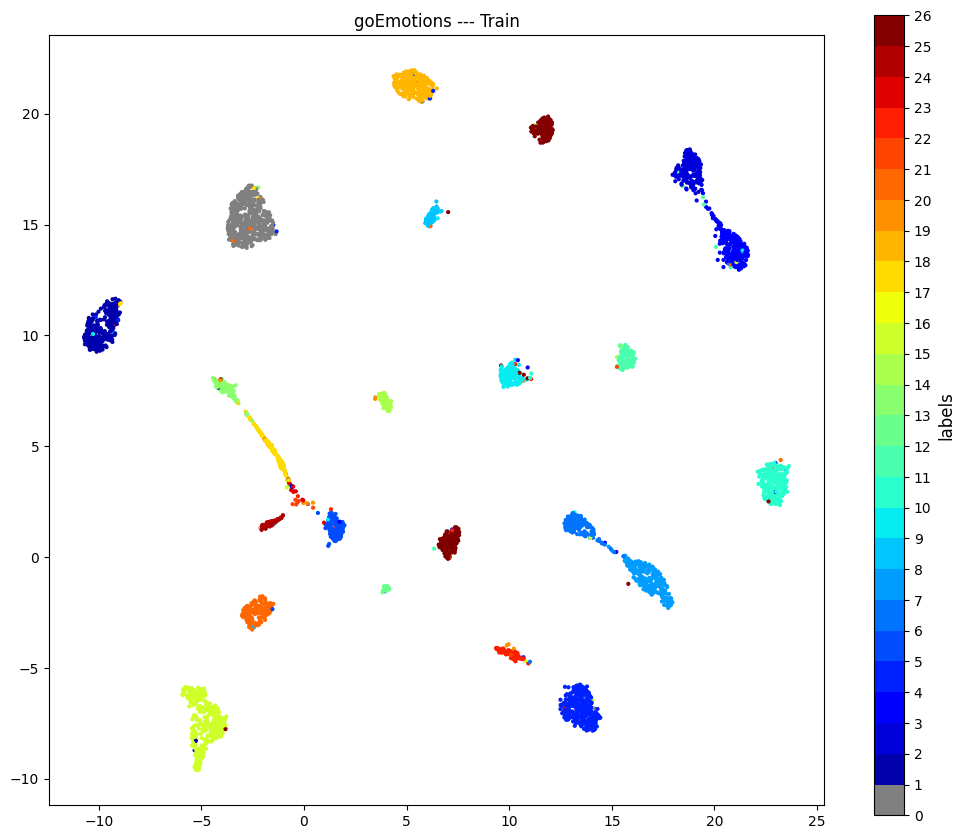

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt


fig, ax = plt.subplots(1, 1, figsize=(10,10))

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 26, 27)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=train_labels, s=4,
                  cmap=cmap, norm=norm)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

# Show the plot
ax.set_title('goEmotions --- Train')
ax2.set_ylabel('labels', size=12)
fig.show()

In [ ]:
# Apply UMAP to the embeddings to obtain a 2D projection
umap_embeddings = umap.UMAP(n_neighbors=27, min_dist=0.3).fit_transform(test_stack_outs)


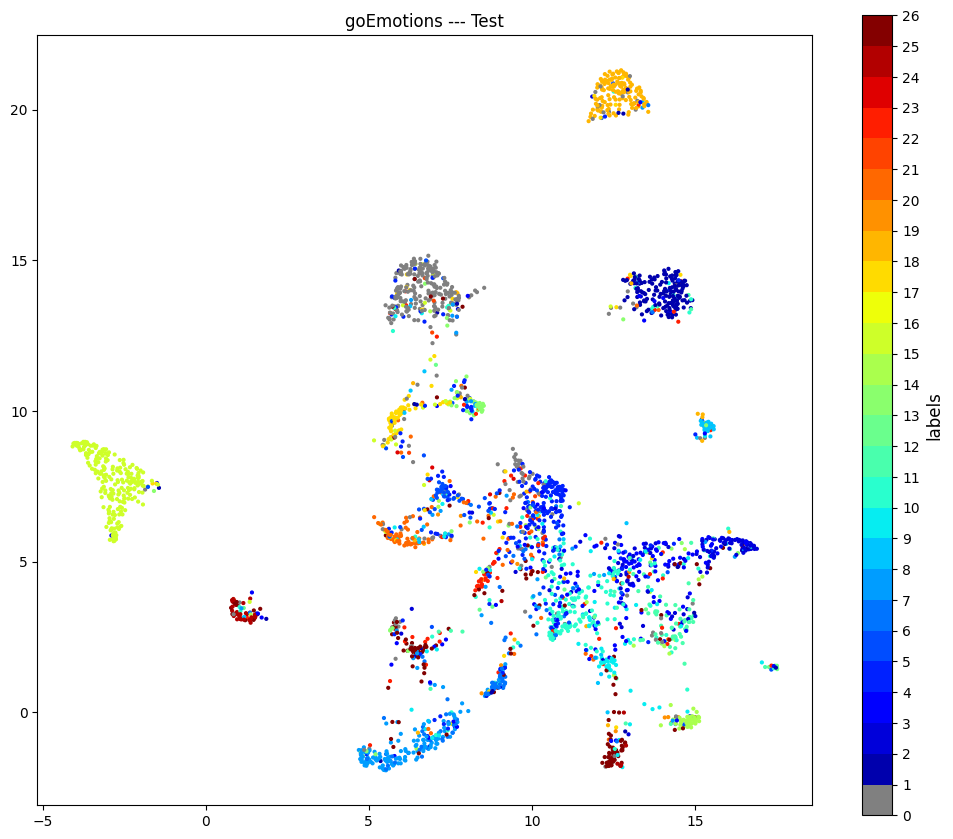

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt


fig, ax = plt.subplots(1, 1, figsize=(10,10))

cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 26, 27)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# make the scatter
scat = ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=test_labels, s=4,
                  cmap=cmap, norm=norm)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

# Show the plot
ax.set_title('goEmotions --- Test')
ax2.set_ylabel('labels', size=12)
fig.show()

In [ ]:
classifier_model = LMClassifierHead(model=model, num_labels=num_labels).to(device)
optim = torch.optim.AdamW(classifier_model.parameters(), lr=lr)

In [ ]:
# for i in classifier_model.parameters():
#     print(i.requires_grad)

In [ ]:
num_training_steps = classifier_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optim,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

In [ ]:
f1_metric = load_metric("f1", average='macro')
acc_metric = load_metric("accuracy")

## Test and train funcs

In [ ]:
def train(train_model, optimizer, num_epochs, batch_size, train_dataloader, eval_dataloader, num_training_steps):

    progress_bar_train = tqdm(range(num_training_steps))
    progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))

    best_f1_metric = 0

    for epoch in range(num_epochs):
        train_model.train()
        for batch in train_dataloader:
            optimizer.zero_grad()

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = train_model(**batch)

            loss = outputs.loss
            loss.backward()

            optimizer.step()
            lr_scheduler.step()

            progress_bar_train.update(1)

        train_model.eval()
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = train_model(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            f1_metric.add_batch(predictions=predictions, references=batch["labels"])
            acc_metric.add_batch(predictions=predictions, references=batch["labels"])

            progress_bar_eval.update(1)

        f1 = f1_metric.compute(average='micro')
        acc = acc_metric.compute()
        print(f1, acc)
        if best_f1_metric < f1['f1']:
            best_f1_metric = f1['f1']
            torch.save(train_model.state_dict(), 'classifier.pt')



In [ ]:
def test(test_model, test_dataloader):

    test_model.eval()

    for batch in tqdm(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = test_model(**batch)

        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        # print(predictions)
        # print(batch['labels'])
        f1_metric.add_batch(predictions=predictions, references=batch["labels"])
        acc_metric.add_batch(predictions=predictions, references=batch["labels"])

    print(f1_metric.compute(average='micro')['f1'] * 100)
    print(acc_metric.compute()['accuracy'] * 100)

## Test and Train

In [ ]:
train(classifier_model, optim, classifier_epochs, classifier_batch, train_dataloader, valid_dataloader, num_training_steps)

In [ ]:
classifier_model.load_state_dict(torch.load('classifier.pt'))

In [ ]:
test(classifier_model, test_dataloader)

In [ ]:
model